In [1]:
!wget https://github.com/matteo-ronchetti/torch-radon/raw/master/examples/phantom.npy

--2024-01-13 18:50:44--  https://github.com/matteo-ronchetti/torch-radon/raw/master/examples/phantom.npy
Resolving github.com (github.com)... 140.82.121.4
Connecting to github.com (github.com)|140.82.121.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/matteo-ronchetti/torch-radon/master/examples/phantom.npy [following]
--2024-01-13 18:50:44--  https://raw.githubusercontent.com/matteo-ronchetti/torch-radon/master/examples/phantom.npy
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.108.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1048704 (1.0M) [application/octet-stream]
Saving to: ‘phantom.npy’

phantom.npy         100%[===================>]   1.00M  --.-KB/s    in 0.02s   

2024-01-13 18:50:45 (51.8 MB/s) - ‘phantom.npy’ saved [1048704/1048

In [13]:
import torch
import numpy as np
import torch.nn.functional as F
from torch.utils.data import Dataset
from torch.optim.lr_scheduler import MultiStepLR
import torch.optim as optim
from torch.utils.data.dataloader import DataLoader

def ssim_loss(img1, img2, size=11,sigma = 1.5, cs_map=False):
    if isinstance(img1, torch.Tensor):
        img1 = img1.unsqueeze(0)
        img2 = img2.unsqueeze(0)

    window = fspecial_gauss(size, sigma)
    window = torch.from_numpy(window.copy()).unsqueeze(0).unsqueeze(0).type(torch.FloatTensor).cuda()
    window = torch.nn.Parameter(data=window, requires_grad=False)
    K1 = 0.001
    K2 = 0.03
    L = 2.0
    C1 = (K1 * L) ** 2
    C2 = (K2 * L) ** 2
    mu1 = F.conv2d(img1,window)
    mu2 = F.conv2d(img2,window)

    mu1_sq = mu1 * mu1
    mu2_sq = mu2 * mu2
    mu1_mu2 = mu1 * mu2
    sigma1_sq = F.conv2d(img1 * img1, window )- mu1_sq
    sigma2_sq = F.conv2d(img2 * img2, window )- mu2_sq
    sigma12 = F.conv2d(img1 * img2, window )- mu1_mu2
    
    if cs_map:
        return (((2 * mu1_mu2 + C1) * (2 * sigma12 + C2)) / ((mu1_sq + mu2_sq + C1) *
                                                             (sigma1_sq + sigma2_sq + C2)),
                (2.0 * sigma12 + C2) / (sigma1_sq + sigma2_sq + C2))
    else:
        ssim = ((2 * mu1_mu2 + C1) * (2 * sigma12 + C2)) / ((mu1_sq + mu2_sq + C1) *
                                                            (sigma1_sq + sigma2_sq + C2))
        ssim = torch.clamp(ssim,min=0.0,max=1.0)
        return ssim.mean()

def l2loss_mean(x,y):
    assert x.size() == y.size()
    loss = torch.sum((x-y) ** 2)
    return loss

def fspecial_gauss(size, sigma):
    x, y = np.mgrid[-size // 2 + 1:size // 2 + 1, -size // 2 + 1:size // 2 + 1]
    g = np.exp(-((x ** 2 + y ** 2) / (2.0 * sigma ** 2)))
    return g / g.sum()

class dataset(Dataset):
    def __init__(self, im1, im2, im3):
        super(dataset, self).__init__()
        self.im1 = im1
        self.im2 = im2
        self.im3 = im3

    def __getitem__(self, index):
        return self.im1[index,], self.im2[index,], self.im3[index,]

    def __len__(self):
        return self.im1.[0]



class Trainer():
    def __init__(self, args, model, dataloader):
 
        self.model = model
        self.epoch = 10
        self.bat_size = 1
        self.dataloader = dataloader

    def _set_optim(self):
        optimizer_cg = optim.Adam(self.model.unrolled_net.parameters(), lr=1e-3)
        scheduler_cg = MultiStepLR(optimizer_cg, milestones=[30,40], gamma=0.9)
        return optimizer_cg, scheduler_cg

    def tr(self):
        self.optimizer, self.scheduler = self._set_optim()
        DLoader = self.dataloader
        n_iter = 0
        for epoch in range(self.epoch):
            for n_count, data_batch in enumerate(DLoader):
                self.optimizer.zero_grad()
                
                batch_sino, batch_u0, batch_img = data_batch[0].cuda(), data_batch[1].cuda(), data_batch[2].cuda()
                batch_x_db = self.model(batch_sino, batch_u0)
                loss = self.loss_fun(batch_x_db, batch_img)
                loss.backward()
                self.optimizer.step()

        self.save_ckp(epoch)

    def loss_fun(self, db, sp):
        layer = len(db)

        loss = 0.0
        for ii in range(0, layer):
            loss =loss+ l2loss_mean(sp, db[ii]) * 1.1**ii

        for ii in range(0, layer):
            for jj in range(sp.shape[1]):
                img1=sp[jj,...]
                img2=db[ii][jj,...]

                ssim_value=1-ssim_loss(img1, img2,size=11,sigma = 1.5)
                loss=loss+ssim_value*100.0

        return loss

    def save_ckp(self, epoch):
        state = {'model': self.model.net.state_dict(),
                 'optimizer': self.optimizer.state_dict(),
                 'scheduler': self.scheduler.state_dict()}
        torch.save(state,'./results/epoch')


In [20]:
import matplotlib
import matplotlib.pyplot as plt
import torch
import numpy as np

device = 'cuda'

xtrue = np.load('0(1).npy')
xfbp = np.load('0.npy')


from modules.operators.RadonTorch import RadonTorch
from modules.operators.Wavelet import Wavelet
import numpy as np
from modules.algorithm.ConjugateGradient import ConjugateGradient as CG
from modules.models.MetaInvNet import *
import torch
import torch_radon as tr

angles = np.linspace(0, np.pi, 52, endpoint=False)
volume = tr.Volume2D()
volume.set_size(height=512, width=512)
radon = RadonTorch(512, angles, volume)
wavelet = Wavelet()

xtrue = torch.FloatTensor(xtrue).unsqueeze(0).to(device)
xfbp = torch.FloatTensor(xfbp).unsqueeze(0).to(device)
sino = radon.transform(xtrue).to(device)

print(xtrue.shape)
print(xfbp.shape)
print(sino.shape)

# _ = plt.imshow(sino.cpu(), cmap="gray") 

# sino = sino.unsqueeze(0).unsqueeze(0)
# xfbp = xfbp.unsqueeze(0).unsqueeze(0)
# model = MetaInvNetL(10, radon, wavelet).to(device)

ds = dataset([sino], [xfbp], [xtrue])
DLoader = DataLoader(dataset=ds, num_workers=4, batch_size=1)

k = next(iter(DLoader))
print(k[0].shape)
print(k[1].shape)

print(k[2].shape)

# lam_over_gamma = 1
# gamma = 1
# Y = radon.transform(x)
# zk = wavelet.transform(x)
# y = model(sino, xfbp, z)

# y = model(sino, xfbp)

# print(y[0].shape)
# print(y[1].shape)
# # cg = CG(100)
# # cg.solve(radon.transposed_transform(radon.transform(x)), torch.zeros(1,1,406,406).to(device), 0, radon, wavelet)


torch.Size([1, 512, 512])
torch.Size([1, 512, 512])
torch.Size([1, 52, 512])


AttributeError: 'list' object has no attribute 'size'

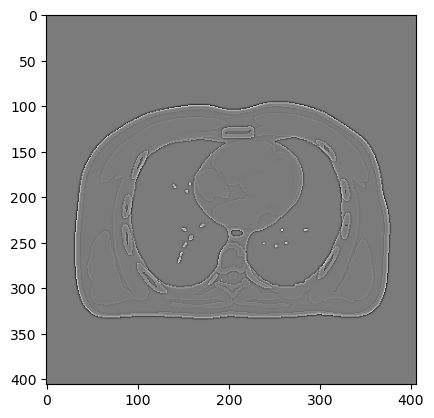

In [13]:
# # import libraries
import matplotlib
import matplotlib.pyplot as plt
# plt.rcParams['figure.figsize'] = [7, 7]
import torch
import numpy as np

# define some constants
batch_size = 1
n_angles = 52
device = torch.device('cuda')

# load phantom and move it to GPU
img = xtrue
image_size = img.shape[0]
x = torch.FloatTensor(img).to(device)

_ = plt.imshow(wavelet.to("cpu"), cmap="gray") 

In [1]:
!pip install opencv-python
!sudo apt update && apt install -y libsm6 libxext6
!sudo apt-get install -y libxrender-dev

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.2/62.2 MB 24.3 MB/s eta 0:00:0000:0100:01
Get:1 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease [1,581 B]
Get:2 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  Packages [662 kB]
Get:3 http://archive.ubuntu.com/ubuntu jammy InRelease [270 kB]        
Get:4 http://security.ubuntu.com/ubuntu jammy-security InRelease [110 kB]      
Get:5 http://archive.ubuntu.com/ubuntu jammy-updates InRelease [119 kB]        
Get:6 http://security.ubuntu.com/ubuntu jammy-security/restricted amd64 Packages [1,595 kB]
Get:7 http://archive.ubuntu.com/ubuntu jammy-backports InRelease [109 kB]
Get:8 http://archive.ubuntu.com/ubuntu jammy/multiverse amd64 Packages [266 kB]3m
Get:9 http://archive.ubuntu.com/ubuntu jammy/main amd64 Packages [1,792 kB]
Get:10 http://security.ubuntu.com/ubuntu jammy-security/main amd64 Packages [1,340 kB]
Get:11 http://security.ubuntu.com/ubuntu jammy-security/universe a